In [2]:
import pandas as pd
import numpy as np
import datetime as dt
import plotly.express as px
import plotly.graph_objects as go


#for quick viz
import seaborn as sns

#ml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import random

In [3]:
df = pd.read_csv('auto_insurance_csv.csv')
df = df.drop(['_c39','Unnamed: 0'], axis = 1)
df['umbrella_limit'] = df.umbrella_limit.fillna("9999")
df['police_report_available'] = df.police_report_available.fillna("MISSING")
df['policy_csl'] = df.policy_csl.fillna("MISSING")
df['policy_bind_date'] = pd.to_datetime(df['policy_bind_date'])
df['incident_date'] = pd.to_datetime(df['incident_date'])
df['claim_day_of_policy'] = (df.incident_date -  df.policy_bind_date).dt.days
df['location_check'] = np.nan
df['location_check'] = np.where(df['policy_state'] == df['incident_state'], True, False)
df['fraud_reported'] = df['fraud_reported'].str.replace('Y', '1')
df['fraud_reported'] = df['fraud_reported'].str.replace('N', '0')
df['fraud_reported'] = df['fraud_reported'].astype(int)
df['umbrella_limit'] = df.umbrella_limit.astype(str)
umbrealla = df['umbrella_limit'].unique()
for umb in umbrealla:
  if (umb != '0.0') & (umb != '9999'):
    df['umbrella_limit'] = df['umbrella_limit'].str.replace(umb, 'other')
    
hobbies = df['insured_hobbies'].unique()
for hobby in hobbies:
  if (hobby != 'chess') & (hobby != 'cross-fit'):
    df['insured_hobbies'] = df['insured_hobbies'].str.replace(hobby, 'other')

df['age'] = df.age.fillna(9999)
bin_labels = ['15-20', '21-25', '26-30', '31-35', '36-40', '41-45', '46-50', '51-55', '56-60', '61-65','9999']
bins = [15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 9999]

df['age_group'] = pd.cut(df['age'], bins = bins, labels = bin_labels, include_lowest = True)
bins = [0, 50, 100, 150, 200, 250, 300, 350, 400, 450, 500]
bin_labels = ['0-50','51-100','101-150','151-200','201-250','251-300','301-350','351-400','401-450','451-500']

df['months_as_customer_groups'] = pd.cut(df['months_as_customer'], bins = 10, labels = bin_labels, include_lowest= True)
bins = list(np.linspace(0,2500, 6, dtype = int))
bin_labels = ['very low', 'low', 'medium', 'high', 'very high']

df['policy_annual_premium_groups'] = pd.cut(df['policy_annual_premium'], bins = bins, labels=bin_labels)
bins = list(np.linspace(0,2000, 5, dtype = int))
bin_labels = ['0-500', '501-1000', '1001-1500', '1501-2000']

df['policy_deductable_group'] = pd.cut(df['policy_deductable'], bins = bins, labels = bin_labels)

df = df.drop(['age', 'months_as_customer', 'policy_deductable', 'policy_annual_premium'], axis = 1)
required_columns = ['incident_date','policy_state', 'policy_csl', 'umbrella_limit',
       'insured_zip', 'insured_sex', 'insured_education_level',
       'insured_occupation', 'insured_hobbies', 'insured_relationship',
       'capital-gains', 'capital-loss', 'incident_type', 'collision_type',
       'incident_severity', 'authorities_contacted', 'incident_state',
       'incident_city', 'incident_location', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'total_claim_amount','auto_make',
       'auto_model', 'auto_year', 'fraud_reported', 'claim_day_of_policy',
       'location_check', 'age_group', 'months_as_customer_groups',
       'policy_annual_premium_groups', 'policy_deductable_group']
df1 = df[required_columns]

In [4]:
df1.incident_date.count()

1000

In [5]:
df1_val = df1.sort_values(by='incident_date',ascending=False).head(200)
df2 = df1.sort_values(by='incident_date',ascending=False).tail(800)

In [7]:
df1.sort_values(by='incident_date',ascending=False).head()

,incident_date,policy_state,policy_csl,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,...,auto_make,auto_model,auto_year,fraud_reported,claim_day_of_policy,location_check,age_group,months_as_customer_groups,policy_annual_premium_groups,policy_deductable_group
752,2015-03-01,IL,MISSING,0.0,441533,MALE,PhD,machine-op-inspct,other,unmarried,...,Chevrolet,Tahoe,1997,0,5718,False,9999,401-450,low,0-500
74,2015-03-01,IL,MISSING,0.0,472895,FEMALE,Associate,sales,other,wife,...,BMW,X6,2005,0,3972,False,36-40,201-250,medium,501-1000
914,2015-03-01,OH,MISSING,0.0,436364,FEMALE,JD,transport-moving,cross-fit,own-child,...,Honda,Accord,1998,0,5343,False,36-40,101-150,low,1501-2000
883,2015-03-01,OH,MISSING,0.0,479824,FEMALE,Associate,exec-managerial,other,not-in-family,...,Audi,A5,2005,1,3374,False,31-35,101-150,medium,501-1000
839,2015-03-01,OH,MISSING,0.0,448294,MALE,Associate,protective-serv,other,own-child,...,Dodge,Neon,2011,0,9106,False,41-45,201-250,medium,0-500


In [8]:
df1_val = df1_val.drop(["incident_date"],axis=1)
df2 = df2.drop(["incident_date"],axis=1)

In [9]:
from sklearn.preprocessing import OneHotEncoder
encoder=OneHotEncoder(drop='first',sparse=False)

In [29]:

enc_df = pd.DataFrame(encoder.fit_transform(df2[['age_group']]))
# merge with main df bridge_df on key values
enc_df.head()

,0,1,2,3,4,5,6,7,8,9
0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
cat_cols = ['age_group', 'months_as_customer_groups', 'policy_annual_premium_groups','location_check','policy_deductable_group']
for col in cat_cols:
  df2[col] = df2[col].astype('object')
columns_to_encode = []
for col in df2.columns:
  if df2[col].dtype == 'object':
    columns_to_encode.append(pd.DataFrame(encoder.fit_transform(df2[cat_cols])))



In [22]:
columns_to_encode

[      0    1    2    3    4    5    6    7    8    9   ...   16   17   18  \
 0    0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
 1    0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
 2    0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
 3    0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
 4    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  1.0   
 5    0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
 6    0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
 7    0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  1.0   
 8    0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
 9    0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
 10   0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  ...  0.0  0.0  0.0   
 11   0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.0

In [17]:
cat_cols = ['age_group', 'months_as_customer_groups', 'policy_annual_premium_groups','location_check','policy_deductable_group']
for col in cat_cols:
  df2[col] = df2[col].astype('object')

columns_to_encode = []
for col in df2.columns:
  if df2[col].dtype == 'object':
    columns_to_encode.append(col)

columns_to_encode



['policy_state',
 'policy_csl',
 'umbrella_limit',
 'insured_sex',
 'insured_education_level',
 'insured_occupation',
 'insured_hobbies',
 'insured_relationship',
 'incident_type',
 'collision_type',
 'incident_severity',
 'authorities_contacted',
 'incident_state',
 'incident_city',
 'incident_location',
 'property_damage',
 'police_report_available',
 'auto_make',
 'auto_model',
 'location_check',
 'age_group',
 'months_as_customer_groups',
 'policy_annual_premium_groups',
 'policy_deductable_group']

In [18]:
df2.incident_location.nunique()

800

In [19]:
df2.head()

,policy_state,policy_csl,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,...,auto_make,auto_model,auto_year,fraud_reported,claim_day_of_policy,location_check,age_group,months_as_customer_groups,policy_annual_premium_groups,policy_deductable_group
511,OH,MISSING,0.0,446755,FEMALE,JD,sales,other,husband,0,...,Volkswagen,Jetta,2003,0,4427,False,46-50,251-300,medium,501-1000
894,IN,MISSING,0.0,475891,MALE,MD,priv-house-serv,other,not-in-family,0,...,Suburu,Impreza,2000,0,8921,False,31-35,0-50,medium,0-500
125,IN,MISSING,other,603948,MALE,JD,craft-repair,other,unmarried,47200,...,Ford,Escape,2013,0,205,False,36-40,201-250,medium,501-1000
895,IL,MISSING,0.0,462525,MALE,High School,armed-forces,other,own-child,26500,...,Saab,92x,1998,1,1980,False,36-40,151-200,medium,0-500
485,IN,MISSING,0.0,471366,MALE,Associate,adm-clerical,other,husband,0,...,Nissan,Maxima,1995,0,7692,False,26-30,51-100,medium,1501-2000


In [27]:
df3 = pd.get_dummies(df2, columns = columns_to_encode)

df3.head()

,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,auto_year,fraud_reported,...,months_as_customer_groups_451-500,months_as_customer_groups_51-100,policy_annual_premium_groups_high,policy_annual_premium_groups_low,policy_annual_premium_groups_medium,policy_annual_premium_groups_very high,policy_annual_premium_groups_very low,policy_deductable_group_0-500,policy_deductable_group_1501-2000,policy_deductable_group_501-1000
511,446755,0,-46200,9,1,2,3,6560,2003,0,...,0,0,0,0,1,0,0,0,0,1
894,475891,0,0,6,1,1,3,6000,2000,0,...,0,0,0,0,1,0,0,1,0,0
125,603948,47200,-69700,12,3,2,3,36300,2013,0,...,0,0,0,0,1,0,0,0,0,1
895,462525,26500,0,23,3,0,3,55200,1998,1,...,0,0,0,0,1,0,0,1,0,0
485,471366,0,-31700,0,1,2,1,48290,1995,0,...,0,1,0,0,1,0,0,0,1,0


In [28]:
cols = df3.columns
num_cols = df3._get_numeric_data().columns
list(set(cols) - set(num_cols))

[]

In [29]:
features = []
for col in df3.columns:
  if col != 'fraud_reported':
    features.append(col)

target = 'fraud_reported'

X = df3[features]
y = df3[target]

In [30]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X = sc.fit_transform(X)

In [31]:
X

array([[-0.76745023, -0.90867046, -0.68250677, ..., -0.71374643,
        -0.67616189,  1.36652242],
       [-0.36042417, -0.90867046,  0.96145549, ...,  1.4010578 ,
        -0.67616189, -0.73178456],
       [ 1.42851515,  0.79450874, -1.51872134, ..., -0.71374643,
        -0.67616189,  1.36652242],
       ...,
       [-0.34129942, -0.90867046,  0.96145549, ..., -0.71374643,
         1.47893576, -0.73178456],
       [-0.43466004, -0.90867046,  0.10389076, ...,  1.4010578 ,
        -0.67616189, -0.73178456],
       [ 1.55253963,  0.97493027,  0.96145549, ...,  1.4010578 ,
        -0.67616189, -0.73178456]])

In [32]:
oversample = SMOTE(random_state=9)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,  random_state = 42)
X_over, y_over = oversample.fit_resample(X_train, y_train)
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size = 0.3, random_state = 1)

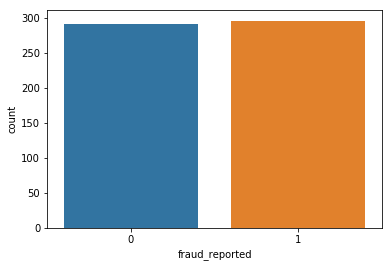

In [33]:
chck = pd.DataFrame()
chck['fraud_reported'] = y_train

sns.countplot(chck['fraud_reported'])


92.06349206349206

              precision    recall  f1-score   support

           0       0.89      0.96      0.92       128
           1       0.96      0.88      0.92       124

    accuracy                           0.92       252
   macro avg       0.92      0.92      0.92       252
weighted avg       0.92      0.92      0.92       252



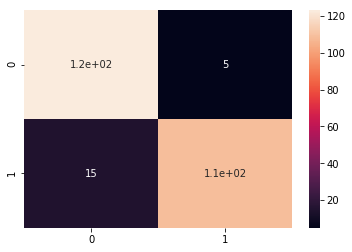

In [34]:
rfc = RandomForestClassifier(random_state = 1)
rfc.fit(X_train, y_train)

preds = rfc.predict(X_test)

score = rfc.score(X_test, y_test)
print(score*100)
print()
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns
sns.heatmap(cm, annot=True)

![LOG](random_forest.png)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 300, stop = 1000, num = 3)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(5, 30, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

{'n_estimators': [300, 650, 1000], 'max_features': ['auto', 'sqrt'], 'max_depth': [5, 17, 30, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}
Fitting 3 folds for each of 100 candidates, totalling 300 fits


In [ ]:
rf_random.best_params_

In [ ]:
rf2 = RandomForestClassifier(n_estimators=650,min_samples_split=2,min_samples_leaf=1,max_features='auto'
                            ,max_depth=None,bootstrap='False')
rf2.fit(X_train, y_train)

preds = rf2.predict(X_test)

score = rf2.score(X_test, y_test)
print(score*100)
print()
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns
sns.heatmap(cm, annot=True)

In [458]:
cat_cols = ['age_group', 'months_as_customer_groups', 'policy_annual_premium_groups','location_check','policy_deductable_group']
for col in cat_cols:
  df1_val[col] = df1_val[col].astype('object')

columns_to_encode = []
for col in df1_val.columns:
  if df1_val[col].dtype == 'object':
    columns_to_encode.append(col)

df2_val = pd.get_dummies(df1_val, columns = columns_to_encode)



In [471]:
df1_val.incident_location.nunique()

200

In [472]:
cols = df2_val.columns
num_cols = df2_val._get_numeric_data().columns
list(set(cols) - set(num_cols))

[]

In [460]:
features = []
for col in df2_val.columns:
  if col != 'fraud_reported':
    features.append(col)

target = 'fraud_reported'

X_val = df2_val[features]
y_val = df2_val[target]

In [462]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_val = sc.fit_transform(X_val)

In [463]:
X_val

array([[-0.80281308,  1.13245318,  0.92396316, ...,  1.33333333,
        -0.62360956, -0.75      ],
       [-0.36702199, -0.87590401,  0.92396316, ..., -0.75      ,
        -0.62360956,  1.33333333],
       [-0.87463899, -0.87590401, -1.46713501, ..., -0.75      ,
         1.60356745, -0.75      ],
       ...,
       [ 1.40817155, -0.87590401,  0.92396316, ...,  1.33333333,
        -0.62360956, -0.75      ],
       [-0.5989659 , -0.87590401, -0.97464016, ..., -0.75      ,
         1.60356745, -0.75      ],
       [-0.79300285,  0.68576077, -1.62773116, ..., -0.75      ,
        -0.62360956,  1.33333333]])

In [464]:
preds = rfc.predict(X_val)
score = rfc.score(X_val, y_val)
print(score*100)
print()
print(classification_report(y_val, preds))

cm = confusion_matrix(y_val, preds)
sns
sns.heatmap(cm, annot=True)

ValueError: X has 369 features, but RandomForestClassifier is expecting 974 features as input.

In [465]:
len(df3.columns)

975

In [466]:
df3.head()

,insured_zip,capital-gains,capital-loss,incident_hour_of_the_day,number_of_vehicles_involved,bodily_injuries,witnesses,total_claim_amount,auto_year,fraud_reported,...,months_as_customer_groups_451-500,months_as_customer_groups_51-100,policy_annual_premium_groups_high,policy_annual_premium_groups_low,policy_annual_premium_groups_medium,policy_annual_premium_groups_very high,policy_annual_premium_groups_very low,policy_deductable_group_0-500,policy_deductable_group_1501-2000,policy_deductable_group_501-1000
511,446755,0,-46200,9,1,2,3,6560,2003,0,...,0,0,0,0,1,0,0,0,0,1
894,475891,0,0,6,1,1,3,6000,2000,0,...,0,0,0,0,1,0,0,1,0,0
125,603948,47200,-69700,12,3,2,3,36300,2013,0,...,0,0,0,0,1,0,0,0,0,1
895,462525,26500,0,23,3,0,3,55200,1998,1,...,0,0,0,0,1,0,0,1,0,0
485,471366,0,-31700,0,1,2,1,48290,1995,0,...,0,1,0,0,1,0,0,0,1,0


In [467]:
len(df2_val.columns)

370

In [473]:
len(df3.columns) - len(df2_val.columns)

605

In [438]:
lst = []
for i in df3.columns:
    if i not in df2_val.columns:
        lst.append(i)
    else:
        pass

In [439]:
len(lst)

805

95.63492063492063

              precision    recall  f1-score   support

           0       0.99      0.92      0.96       128
           1       0.92      0.99      0.96       124

    accuracy                           0.96       252
   macro avg       0.96      0.96      0.96       252
weighted avg       0.96      0.96      0.96       252



<AxesSubplot:>

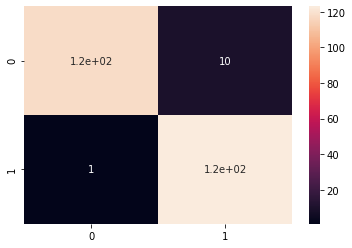

In [398]:
df3 = df2.apply(LabelEncoder().fit_transform)
df3.head()

features = []
for col in df3.columns:
  if col != 'fraud_reported':
    features.append(col)

target = 'fraud_reported'

X = df3[features]
y = df3[target]

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X = sc.fit_transform(X)

oversample = SMOTE(random_state=9)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,  random_state = 42)
X_over, y_over = oversample.fit_resample(X_train, y_train)
X_train, X_test, y_train, y_test = train_test_split(X_over, y_over, test_size = 0.3, random_state = 1)

rfc = RandomForestClassifier(random_state = 1)
rfc.fit(X_train, y_train)

preds = rfc.predict(X_test)

score = rfc.score(X_test, y_test)
print(score*100)
print()
print(classification_report(y_test, preds))

cm = confusion_matrix(y_test, preds)
sns
sns.heatmap(cm, annot=True)

80.0

              precision    recall  f1-score   support

           0       0.94      0.80      0.87       163
           1       0.48      0.78      0.59        37

    accuracy                           0.80       200
   macro avg       0.71      0.79      0.73       200
weighted avg       0.86      0.80      0.82       200



<AxesSubplot:>

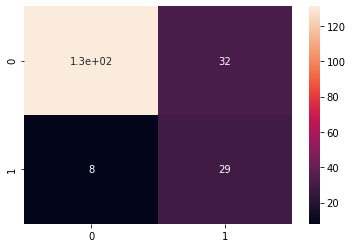

In [399]:
df3_val = df1_val.apply(LabelEncoder().fit_transform)
df3.head()

features = []
for col in df3_val.columns:
  if col != 'fraud_reported':
    features.append(col)

target = 'fraud_reported'

X_val = df3_val[features]
y_val = df3_val[target]

from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_val = sc.fit_transform(X_val)

preds = rfc.predict(X_val)

score = rfc.score(X_val, y_val)
print(score*100)
print()
print(classification_report(y_val, preds))

cm = confusion_matrix(y_val, preds)
sns
sns.heatmap(cm, annot=True)

In [400]:
df1_val

,policy_state,policy_csl,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,...,auto_make,auto_model,auto_year,fraud_reported,claim_day_of_policy,location_check,age_group,months_as_customer_groups,policy_annual_premium_groups,policy_deductable_group
752,IL,MISSING,0.0,441533,MALE,PhD,machine-op-inspct,other,unmarried,57100,...,Chevrolet,Tahoe,1997,0,5718,False,9999,401-450,low,0-500
74,IL,MISSING,0.0,472895,FEMALE,Associate,sales,other,wife,0,...,BMW,X6,2005,0,3972,False,36-40,201-250,medium,501-1000
914,OH,MISSING,0.0,436364,FEMALE,JD,transport-moving,cross-fit,own-child,0,...,Honda,Accord,1998,0,5343,False,36-40,101-150,low,1501-2000
883,OH,MISSING,0.0,479824,FEMALE,Associate,exec-managerial,other,not-in-family,0,...,Audi,A5,2005,1,3374,False,31-35,101-150,medium,501-1000
839,OH,MISSING,0.0,448294,MALE,Associate,protective-serv,other,own-child,0,...,Dodge,Neon,2011,0,9106,False,41-45,201-250,medium,0-500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
539,IN,MISSING,0.0,442210,FEMALE,College,prof-specialty,other,other-relative,45400,...,BMW,X5,2015,0,5349,False,9999,201-250,medium,1501-2000
937,IN,MISSING,0.0,472236,FEMALE,High School,protective-serv,other,wife,31400,...,Jeep,Grand Cherokee,1995,0,2175,False,56-60,451-500,high,501-1000
77,IN,MISSING,9999,600648,MALE,College,transport-moving,other,not-in-family,0,...,Audi,A3,2005,0,8344,False,46-50,301-350,medium,0-500
835,IN,MISSING,other,456203,MALE,JD,other-service,other,wife,0,...,Mercedes,ML350,2015,0,787,False,51-55,351-400,medium,1501-2000


In [401]:
df4 = pd.concat([df2,df3],axis=1)

In [402]:
df4.columns

Index(['policy_state', 'policy_csl', 'umbrella_limit', 'insured_zip',
       'insured_sex', 'insured_education_level', 'insured_occupation',
       'insured_hobbies', 'insured_relationship', 'capital-gains',
       'capital-loss', 'incident_type', 'collision_type', 'incident_severity',
       'authorities_contacted', 'incident_state', 'incident_city',
       'incident_location', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'total_claim_amount',
       'auto_make', 'auto_model', 'auto_year', 'fraud_reported',
       'claim_day_of_policy', 'location_check', 'age_group',
       'months_as_customer_groups', 'policy_annual_premium_groups',
       'policy_deductable_group', 'policy_state', 'policy_csl',
       'umbrella_limit', 'insured_zip', 'insured_sex',
       'insured_education_level', 'insured_occupation', 'insured_hobbies',
       'insured_relationship', 'capital-gains', 'capital-

In [403]:
df4 = df2
for i in df2.columns:
    df4[i+"_v1"] = df3[i]
    

In [404]:
df4.columns

Index(['policy_state', 'policy_csl', 'umbrella_limit', 'insured_zip',
       'insured_sex', 'insured_education_level', 'insured_occupation',
       'insured_hobbies', 'insured_relationship', 'capital-gains',
       'capital-loss', 'incident_type', 'collision_type', 'incident_severity',
       'authorities_contacted', 'incident_state', 'incident_city',
       'incident_location', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'total_claim_amount',
       'auto_make', 'auto_model', 'auto_year', 'fraud_reported',
       'claim_day_of_policy', 'location_check', 'age_group',
       'months_as_customer_groups', 'policy_annual_premium_groups',
       'policy_deductable_group', 'policy_state_v1', 'policy_csl_v1',
       'umbrella_limit_v1', 'insured_zip_v1', 'insured_sex_v1',
       'insured_education_level_v1', 'insured_occupation_v1',
       'insured_hobbies_v1', 'insured_relationship_v1',

In [405]:
df4

,policy_state,policy_csl,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,...,auto_make_v1,auto_model_v1,auto_year_v1,fraud_reported_v1,claim_day_of_policy_v1,location_check_v1,age_group_v1,months_as_customer_groups_v1,policy_annual_premium_groups_v1,policy_deductable_group_v1
511,OH,MISSING,0.0,446755,FEMALE,JD,sales,other,husband,0,...,13,20,8,0,343,0,6,4,2,2
894,IN,MISSING,0.0,475891,MALE,MD,priv-house-serv,other,not-in-family,0,...,11,19,5,0,746,0,3,0,2,0
125,IN,MISSING,other,603948,MALE,JD,craft-repair,other,unmarried,47200,...,5,13,18,0,17,0,4,3,2,2
895,IL,MISSING,0.0,462525,MALE,High School,armed-forces,other,own-child,26500,...,10,1,3,1,149,0,4,2,2,0
485,IN,MISSING,0.0,471366,MALE,Associate,adm-clerical,other,husband,0,...,9,26,0,0,624,0,2,9,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
833,IN,MISSING,0.0,472814,FEMALE,JD,machine-op-inspct,other,other-relative,0,...,5,14,16,0,685,0,2,1,0,0
457,IL,100/300,0.0,470559,MALE,Masters,transport-moving,other,own-child,38000,...,13,28,16,1,64,0,2,1,0,1
478,IL,500/1000,9999,477260,MALE,Masters,armed-forces,chess,unmarried,0,...,8,7,6,1,480,0,7,7,1,1
41,IN,250/500,0.0,470577,MALE,Associate,transport-moving,chess,unmarried,0,...,2,37,6,1,75,0,10,1,0,0


In [406]:
df4[['policy_state','policy_state_v1']].drop_duplicates()

for i in df3.columns:
    df_change = df4[[i,i+"_v1"]].drop_duplicates()
    df1_val = df1_val.merge(df_change,how='left',on=i)

In [407]:
df2_val = df1_val.drop(['policy_state', 'policy_csl', 'umbrella_limit', 'insured_zip',
       'insured_sex', 'insured_education_level', 'insured_occupation',
       'insured_hobbies', 'insured_relationship', 'capital-gains',
       'capital-loss', 'incident_type', 'collision_type', 'incident_severity',
       'authorities_contacted', 'incident_state', 'incident_city',
       'incident_location', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'total_claim_amount',
       'auto_make', 'auto_model', 'auto_year', 'fraud_reported',
       'claim_day_of_policy', 'location_check', 'age_group',
       'months_as_customer_groups', 'policy_annual_premium_groups',
       'policy_deductable_group'],axis=1)
df2_val.columns = ['policy_state', 'policy_csl', 'umbrella_limit', 'insured_zip',
       'insured_sex', 'insured_education_level', 'insured_occupation',
       'insured_hobbies', 'insured_relationship', 'capital-gains',
       'capital-loss', 'incident_type', 'collision_type', 'incident_severity',
       'authorities_contacted', 'incident_state', 'incident_city',
       'incident_location', 'incident_hour_of_the_day',
       'number_of_vehicles_involved', 'property_damage', 'bodily_injuries',
       'witnesses', 'police_report_available', 'total_claim_amount',
       'auto_make', 'auto_model', 'auto_year', 'fraud_reported',
       'claim_day_of_policy', 'location_check', 'age_group',
       'months_as_customer_groups', 'policy_annual_premium_groups',
       'policy_deductable_group']
df2_val

,policy_state,policy_csl,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,...,auto_make,auto_model,auto_year,fraud_reported,claim_day_of_policy,location_check,age_group,months_as_customer_groups,policy_annual_premium_groups,policy_deductable_group
0,0,3,0,NaN,1,6,6,2,4,186.0,...,3,34,2,0,NaN,0,10,7,1,0
1,0,3,0,NaN,0,0,11,2,5,0.0,...,2,38,10,0,NaN,0,4,3,2,2
2,2,3,0,NaN,0,3,13,1,3,0.0,...,6,6,3,0,425.0,0,4,1,1,1
3,2,3,0,NaN,0,0,3,2,1,0.0,...,1,5,10,1,NaN,0,3,1,2,2
4,2,3,0,NaN,1,0,10,2,3,0.0,...,4,27,16,0,NaN,0,5,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1,3,0,NaN,0,1,9,2,2,NaN,...,2,37,20,0,NaN,0,10,3,2,1
196,1,3,0,NaN,0,2,10,2,5,NaN,...,7,17,0,0,NaN,0,8,8,0,2
197,1,3,1,NaN,1,1,13,2,1,0.0,...,1,4,10,0,NaN,0,6,5,2,0
198,1,3,2,NaN,1,3,7,2,5,0.0,...,8,24,20,0,NaN,0,7,6,2,1


In [408]:
df2_val.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 0 to 199
Data columns (total 35 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   policy_state                  200 non-null    int32  
 1   policy_csl                    200 non-null    int32  
 2   umbrella_limit                200 non-null    int32  
 3   insured_zip                   1 non-null      float64
 4   insured_sex                   200 non-null    int32  
 5   insured_education_level       200 non-null    int32  
 6   insured_occupation            200 non-null    int32  
 7   insured_hobbies               200 non-null    int32  
 8   insured_relationship          200 non-null    int32  
 9   capital-gains                 146 non-null    float64
 10  capital-loss                  147 non-null    float64
 11  incident_type                 200 non-null    int32  
 12  collision_type                200 non-null    int32  
 13  incid

In [409]:
df3_val = df2_val
for i in df3_val.columns:
    maximum = df4[i+"_v1"].max() + 1
    df3_val[i] = df3_val[i].fillna(maximum)

In [410]:
df3_val

,policy_state,policy_csl,umbrella_limit,insured_zip,insured_sex,insured_education_level,insured_occupation,insured_hobbies,insured_relationship,capital-gains,...,auto_make,auto_model,auto_year,fraud_reported,claim_day_of_policy,location_check,age_group,months_as_customer_groups,policy_annual_premium_groups,policy_deductable_group
0,0,3,0,796.0,1,6,6,2,4,186.0,...,3,34,2,0,769.0,0,10,7,1,0
1,0,3,0,796.0,0,0,11,2,5,0.0,...,2,38,10,0,769.0,0,4,3,2,2
2,2,3,0,796.0,0,3,13,1,3,0.0,...,6,6,3,0,425.0,0,4,1,1,1
3,2,3,0,796.0,0,0,3,2,1,0.0,...,1,5,10,1,769.0,0,3,1,2,2
4,2,3,0,796.0,1,0,10,2,3,0.0,...,4,27,16,0,769.0,0,5,3,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,1,3,0,796.0,0,1,9,2,2,288.0,...,2,37,20,0,769.0,0,10,3,2,1
196,1,3,0,796.0,0,2,10,2,5,288.0,...,7,17,0,0,769.0,0,8,8,0,2
197,1,3,1,796.0,1,1,13,2,1,0.0,...,1,4,10,0,769.0,0,6,5,2,0
198,1,3,2,796.0,1,3,7,2,5,0.0,...,8,24,20,0,769.0,0,7,6,2,1


81.0

              precision    recall  f1-score   support

           0       0.82      0.98      0.89       163
           1       0.40      0.05      0.10        37

    accuracy                           0.81       200
   macro avg       0.61      0.52      0.49       200
weighted avg       0.74      0.81      0.75       200



C:\Users\mertt\Anaconda3\lib\site-packages\sklearn\base.py:434: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
C:\Users\mertt\Anaconda3\lib\site-packages\sklearn\base.py:434: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


<AxesSubplot:>

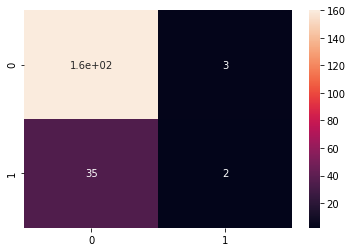

In [411]:
X_val = df3_val[features]
y_val = df3_val[target]

preds = rfc.predict(X_val)

score = rfc.score(X_val, y_val)
print(score*100)
print()
print(classification_report(y_val, preds))

cm = confusion_matrix(y_val, preds)
sns
sns.heatmap(cm, annot=True)